In [43]:
import orca
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from urbansim_templates import modelmanager
from urbansim_templates.models.regression import RandomForestRegressionStep, OLSRegressionStep, GradientBoostingRegressionStep
from urbansim_templates.models.neuro_network import NeuralNetworkStep

In [2]:
# load rental data
rental = pd.read_csv('data\\rentals_with_nodes.csv')
node_small = pd.read_csv('data\\nodessmall_vars.csv') 
node_walk = pd.read_csv('data\\nodeswalk_vars.csv') 

In [40]:
data = pd.merge(rental, node_small, left_on='node_id_small', right_on='osmid')
data = pd.merge(data, node_walk, left_on='node_id_walk', right_on='osmid')


In [4]:
# register data in orca
orca.add_table('rental_prices', data)

In [6]:
# create random forest step 
modelmanager.initialize()

No yaml files found in path 'configs'


In [7]:
# define model expression
model_expression = 'np.log(rent_sqft) ~ bedrooms + np.log1p(units_500_walk) + np.log1p(rich_500_walk) + '\
        'np.log1p(singles_500_walk) + np.log1p(children_500_walk)'

In [8]:
# random forest
rf = RandomForestRegressionStep(out_column='rent_sqft', out_transform=np.exp)
rf.tables = 'rental_prices'
rf.model_expression = model_expression
rf.fit()

In [9]:
# gradient boosting
gb = GradientBoostingRegressionStep(out_column='rent_sqft', out_transform=np.exp)
gb.tables = 'rental_prices'
gb.model_expression = model_expression
gb.fit()

In [10]:
# ols
ols = OLSRegressionStep(out_transform=np.exp, out_column='rent_sqft')
ols.tables = 'rental_prices'
ols.model_expression = model_expression
ols.fit()

                            OLS Regression Results                            
Dep. Variable:      np.log(rent_sqft)   R-squared:                       0.408
Model:                            OLS   Adj. R-squared:                  0.408
Method:                 Least Squares   F-statistic:                 4.301e+04
Date:                Wed, 10 Oct 2018   Prob (F-statistic):               0.00
Time:                        12:23:02   Log-Likelihood:                -17618.
No. Observations:              312325   AIC:                         3.525e+04
Df Residuals:                  312319   BIC:                         3.531e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept         

In [11]:
# two hiiden layers neuro network
nn = NeuralNetworkStep(out_transform=np.exp, out_column='rent_sqft')
nn.tables = 'rental_prices'
nn.model_expression = model_expression
nn.fit(verbose=0, epochs=4, batch_size=16)

In [12]:
# create cross validation metrics
rf.cross_validate_score()
ols.cross_validate_score()
gb.cross_validate_score()
nn.cross_validate_score(verbose=0, epochs=4, batch_size=32)

In [13]:
# summary of cross validation statistics
summary = pd.DataFrame()
summary.loc['ols', 'mse'] = ols.cv_metric['mean_cross_validation']
summary.loc['random forest', 'mse'] = rf.cv_metric['mean_cross_validation']
summary.loc['gradient boosting', 'mse'] = gb.cv_metric['mean_cross_validation']
summary.loc['neuro_net_one_layer', 'mse'] = nn.cv_metric['mean_cross_validation']
summary.loc['ols', 'mae'] = ols.cv_metric['mae_cross_validation']
summary.loc['random forest', 'mae'] = rf.cv_metric['mae_cross_validation']
summary.loc['gradient boosting', 'mae'] = gb.cv_metric['mae_cross_validation']
summary.loc['neuro_net_one_layer', 'mae'] = nn.cv_metric['mae_cross_validation']
summary

,mse,mae
ols,0.693913,0.589260
random forest,0.277779,0.304354
gradient boosting,0.573558,0.525374
neuro_net_one_layer,0.673234,0.574803


In [9]:
# register best model
rf.name = 'random_forest_rental_prices'
modelmanager.register(rf)

Saving 'random_forest_rental_prices.yaml': C:\Users\Xavier\Urbansim\udst\urbansim_templates_testing\urbansim_templates\urbansim_templates\tests\configs
Registering model step 'random_forest_rental_prices'


In [33]:
# check whether it is saved
modelmanager.initialize()

Registering model step 'random_forest_rental_prices'


In [34]:
m = modelmanager.get_step('random_forest_rental_prices')

In [35]:
m.run()

In [41]:
results = pd.DataFrame(m.predicted_values)
results.columns = ['predicted']
results['observed'] = data[m._get_out_column()]

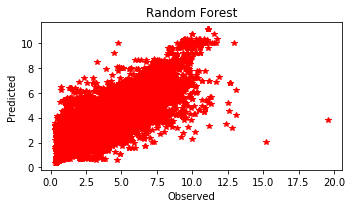

In [45]:
fig, ax = plt.subplots(figsize=(5, 3))
ax.plot(results.observed, results.predicted, 'r*')
ax.set_title('Random Forest')
ax.set_ylabel('Predicted')
ax.set_xlabel('Observed')
fig.tight_layout()

In [27]:
data